Скачаем датасет картинок с 9 видами грибов

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import kagglehub
import torch
import torch.optim as optim
import torchvision
from torchvision.transforms import v2
from torch import nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from random import shuffle
from PIL import Image

path = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mushrooms-classification-common-genuss-images


Определим названия для меток, а так же загрузим данные. Среди данных попадаются поврежденные файлы, поэтому напишем обертку загрузки датасета с пропуском поврежденных файлов. Выведем картинки для понимания с чем работаем.

Classes: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


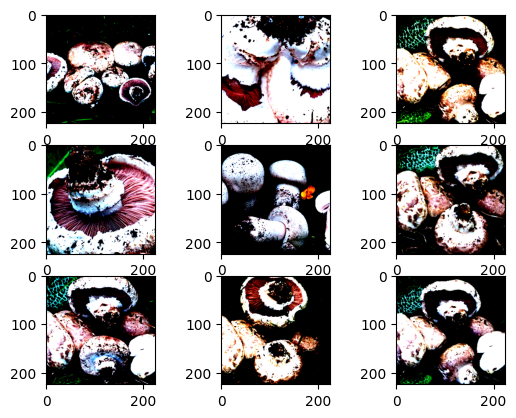

In [17]:
transforms = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224), # центрирует и обрезает изображение
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # нормализует пиксели по каналам для ускорения обучения
])

# Позволяет избежать ошибок при попытке загрузить поврежденные изображения
class SafeImageFolder(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(SafeImageFolder, self).__init__(root, transform)
        self.samples = self._filter_samples()

    def _filter_samples(self):
        valid_samples = []
        for path, target in self.samples:
            try:
                with Image.open(path) as img:
                    img.verify()
                valid_samples.append((path, target))
            except (IOError, SyntaxError) as e:
                print(f"Error loading image {path}: {e}")
        return valid_samples

    def __getitem__(self, index):
        while True:
            path, target = self.samples[index]
            try:
                sample = self.loader(path)
                if self.transform is not None:
                    sample = self.transform(sample)
                return sample, target
            except Exception as e:
                print(f"Error loading image {path}: {e}")
                index = (index + 1) % len(self.samples)

dataset = SafeImageFolder(root="/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms", transform=transforms)

class_names = dataset.classes
print("Classes:", class_names)

f, axarr = plt.subplots(3,3)
for i in range(40, 49):
    data = dataset[i][0]
    axarr[i%3,i//3%3].imshow(np.array(data.permute(1, 2, 0)))

Устанавливаем устройство для вычислений (GPU, если доступен, иначе CPU). Разделим на тренировочный и валидационный наборы по 80% и 20% от данных соответственно. Создадим DataLoader'ы чтобы загружать данные в процессе обучения

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

OUT_FEATURES = 9
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.005

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Using device: cpu


Построим NN с помощью resnet50, загрузим предобученные веса с официального сайта pytorch, изменим выходной слой под наши классы. Так же напишем функцию для обучения NN и отображения истории обучения с расчетом accuracy и confusion matrix для валидации. Будем использовать оптимизатор Adam для ускорения обучения:

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# model = torchvision.models.resnet50(weights=None) // к сожалению kaggle будет обучать 7 часов
model = torchvision.models.resnet18()
model.load_state_dict(torch.load("/kaggle/input/resnet18/pytorch/default/1/resnet18-f37072fd.pth", weights_only=True))
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss() # Функция потерь
optimizer = optim.Adam(model.parameters(), lr=LR) # Adam помогает ускорить сходимость

def train(net, train_loader, val_loader, device, num_epochs, optimizer):
    criterion = torch.nn.CrossEntropyLoss()
    acc_history = []
    val_acc_history = []

    # Отображаем процесс обучения в реальном времени
    with tqdm(total=len(train_loader) * num_epochs, position=0, leave=True) as pbar:
        for epoch in range(num_epochs):
            net.train() # Режим обучения
            running_loss = 0.0
            correct = 0
            total = 0 

            # Обучение
            for batch_num, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.set_description(f"Epoch: {epoch+1}, Batch: {batch_num+1}, Loss: {running_loss/(batch_num+1):.4f}, Acc: {correct/total:.4f}")
                pbar.update()

            # Рассчитываем точность после каждой эпохи
            train_acc = correct / total
            acc_history.append(train_acc)

            # Оценка на валидации
            net.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = net(images)
                    _, preds = torch.max(outputs, 1)

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            # Accuracy Score для валидации
            val_acc = accuracy_score(all_labels, all_preds)
            val_acc_history.append(val_acc)
            print(f"Epoch {epoch+1}/{num_epochs} - Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

            # Confusion Matrix для анализа качества классификации
            cm = confusion_matrix(all_labels, all_preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
            plt.xlabel("Predicted Labels")
            plt.ylabel("True Labels")
            plt.title(f"Confusion Matrix for Epoch {epoch+1}")
            plt.show()

    return acc_history, val_acc_history

# Функция для визуализации графиков тренировки и валидации точности
def print_history(train_history, val_history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_history, label='Train Accuracy')
    plt.plot(val_history, label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Запуск обучения (2 часа):

Epoch: 1, Batch: 84, Loss: 2.2561, Acc: 0.2115:  10%|█         | 84/840 [13:44<1:52:31,  8.93s/it]

Epoch 1/10 - Train Accuracy: 0.2115, Validation Accuracy: 0.2211


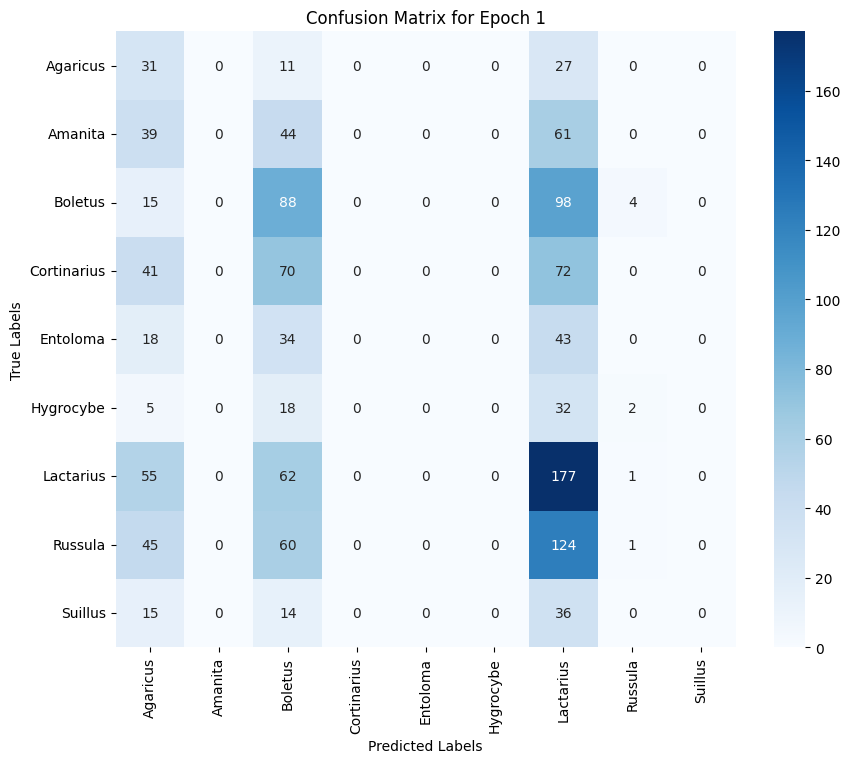

Epoch: 2, Batch: 25, Loss: 2.0469, Acc: 0.2487:  13%|█▎        | 109/840 [19:05<1:58:27,  9.72s/it]

Error loading image /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)


Epoch: 2, Batch: 84, Loss: 2.0108, Acc: 0.2461:  20%|██        | 168/840 [28:41<1:44:18,  9.31s/it]

Epoch 2/10 - Train Accuracy: 0.2461, Validation Accuracy: 0.2591


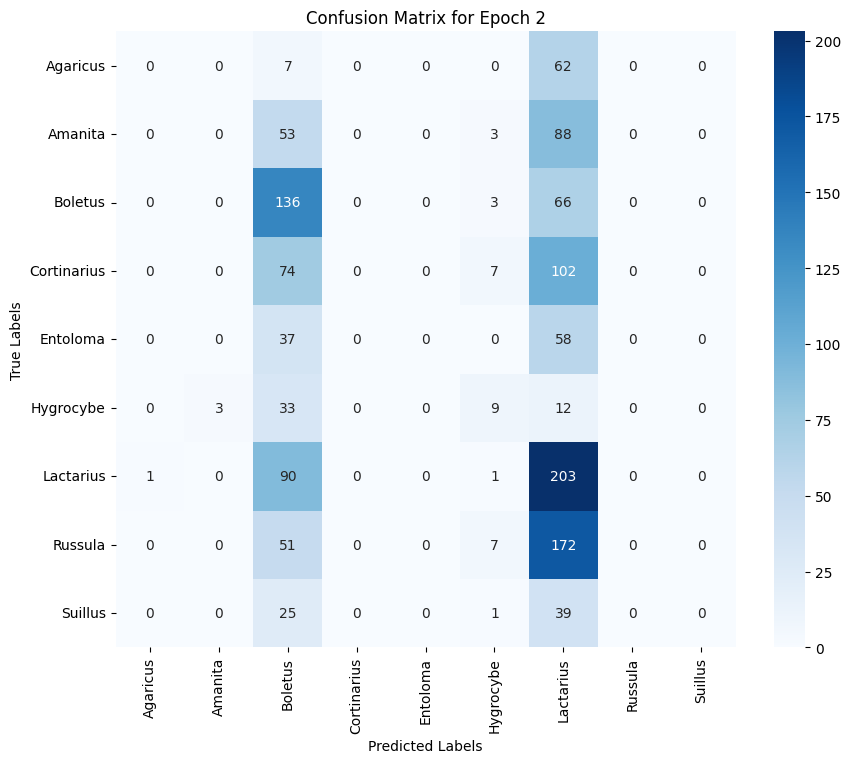

Epoch: 3, Batch: 62, Loss: 1.9094, Acc: 0.2868:  27%|██▋       | 230/840 [40:00<1:35:32,  9.40s/it]

Error loading image /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)


Epoch: 4, Batch: 20, Loss: 1.7694, Acc: 0.3281:  32%|███▏      | 272/840 [48:01<1:30:25,  9.55s/it]

Error loading image /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)


Epoch: 4, Batch: 84, Loss: 1.7675, Acc: 0.3424:  40%|████      | 336/840 [58:15<1:16:26,  9.10s/it]

Epoch 4/10 - Train Accuracy: 0.3424, Validation Accuracy: 0.3321


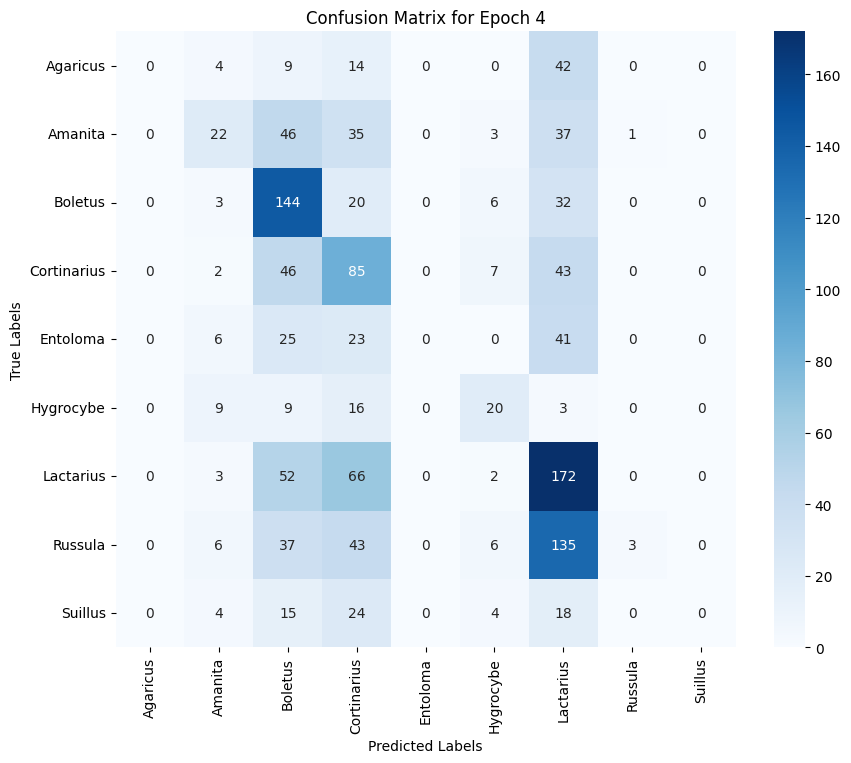

Epoch: 5, Batch: 26, Loss: 1.7043, Acc: 0.3768:  43%|████▎     | 362/840 [1:03:41<1:15:18,  9.45s/it]

Error loading image /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)


Epoch: 5, Batch: 84, Loss: 1.6718, Acc: 0.3994:  50%|█████     | 420/840 [1:12:52<1:04:35,  9.23s/it]

Epoch 5/10 - Train Accuracy: 0.3994, Validation Accuracy: 0.3582


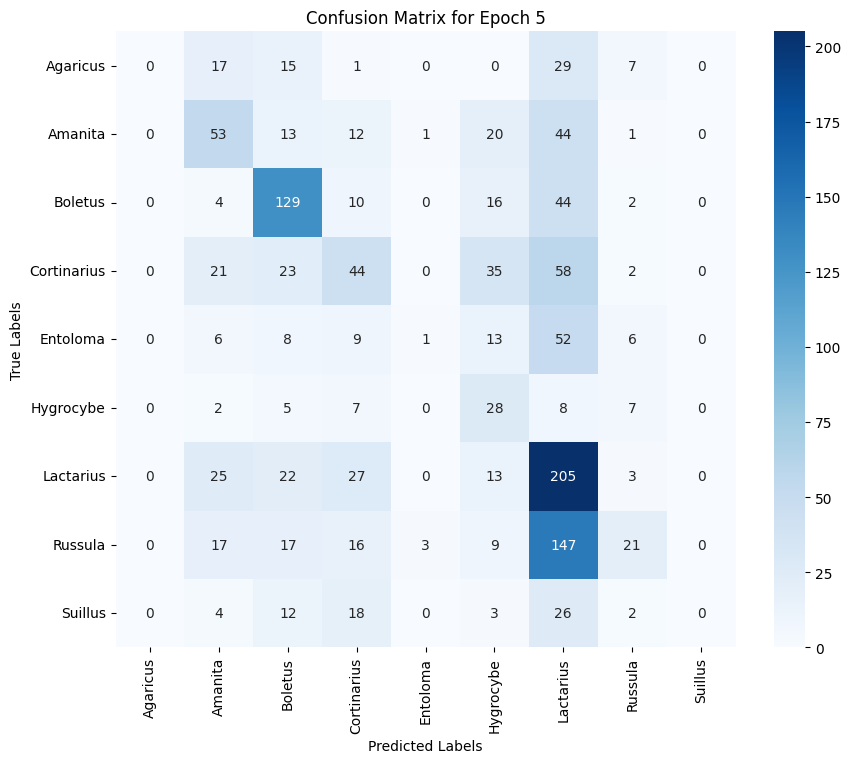

Epoch: 6, Batch: 55, Loss: 1.6231, Acc: 0.4210:  57%|█████▋    | 475/840 [1:22:45<56:24,  9.27s/it]  

Error loading image /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)


Epoch: 6, Batch: 84, Loss: 1.5961, Acc: 0.4381:  60%|██████    | 504/840 [1:27:20<50:11,  8.96s/it]

Epoch 6/10 - Train Accuracy: 0.4381, Validation Accuracy: 0.3864


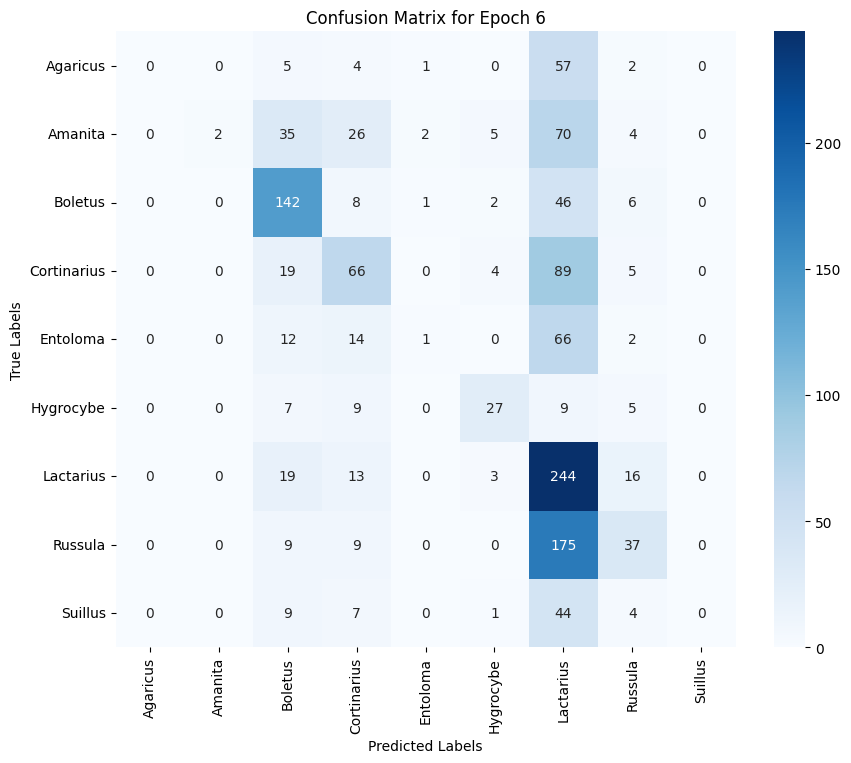

Epoch: 7, Batch: 74, Loss: 1.5134, Acc: 0.4730:  69%|██████▉   | 578/840 [1:40:29<42:26,  9.72s/it]  

Error loading image /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)


Epoch: 7, Batch: 84, Loss: 1.5111, Acc: 0.4724:  70%|███████   | 588/840 [1:42:03<38:47,  9.24s/it]

Epoch 7/10 - Train Accuracy: 0.4724, Validation Accuracy: 0.4594


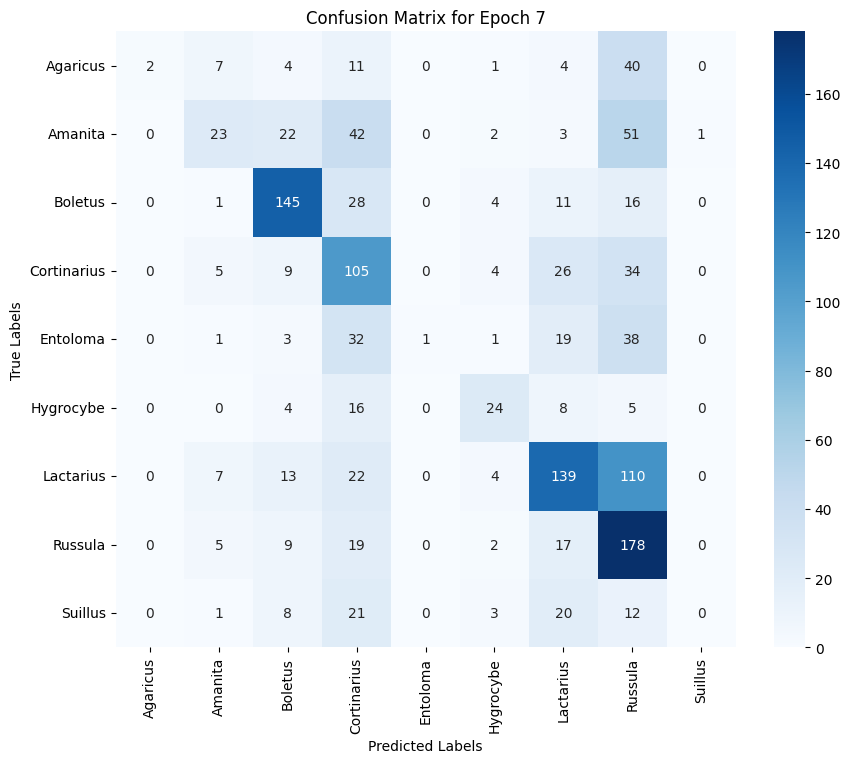

Epoch: 8, Batch: 39, Loss: 1.4296, Acc: 0.5088:  75%|███████▍  | 627/840 [1:49:36<34:41,  9.77s/it] 

Error loading image /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)


Epoch: 8, Batch: 84, Loss: 1.4294, Acc: 0.5066:  80%|████████  | 672/840 [1:56:45<25:01,  8.93s/it]

Epoch 8/10 - Train Accuracy: 0.5066, Validation Accuracy: 0.3209


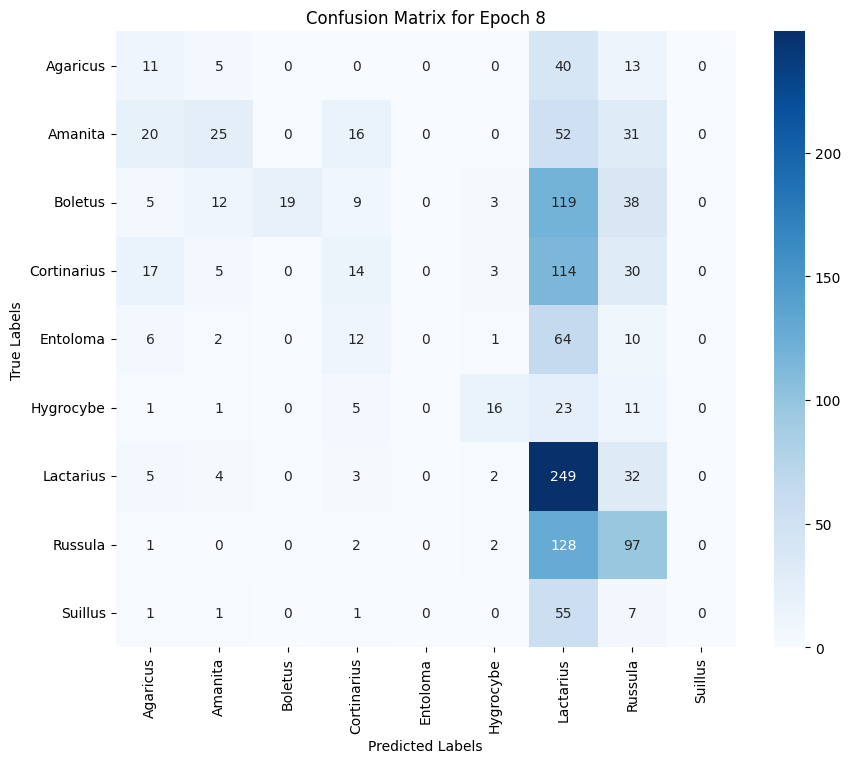

Epoch: 9, Batch: 4, Loss: 1.3130, Acc: 0.5508:  80%|████████  | 676/840 [1:58:38<46:52, 17.15s/it]  

Error loading image /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)


Epoch: 9, Batch: 84, Loss: 1.3779, Acc: 0.5243:  90%|█████████ | 756/840 [2:11:16<12:35,  8.99s/it]

Epoch 9/10 - Train Accuracy: 0.5243, Validation Accuracy: 0.4162


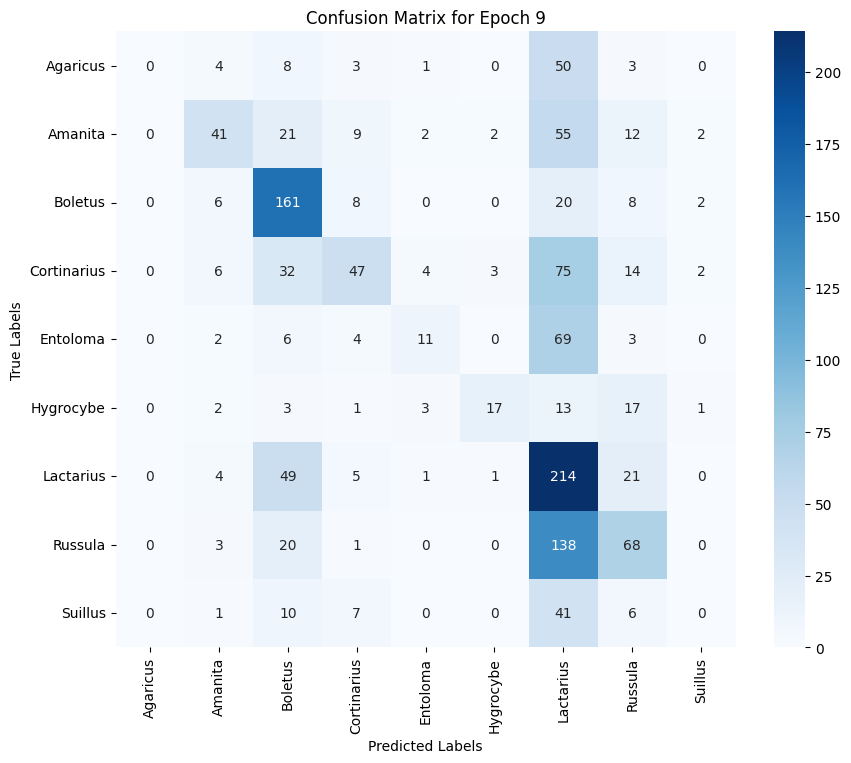

Epoch: 10, Batch: 27, Loss: 1.2913, Acc: 0.5492:  93%|█████████▎| 783/840 [2:16:48<08:56,  9.42s/it]

Error loading image /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)


Epoch: 10, Batch: 84, Loss: 1.2994, Acc: 0.5451: 100%|██████████| 840/840 [2:25:45<00:00,  8.85s/it]

Epoch 10/10 - Train Accuracy: 0.5451, Validation Accuracy: 0.4713


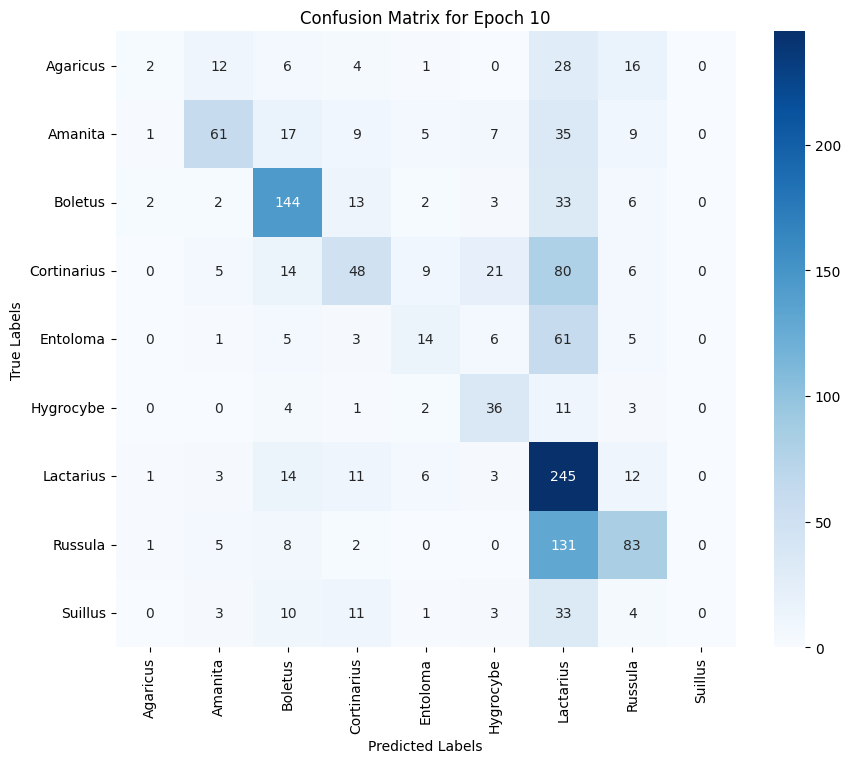

Epoch: 10, Batch: 84, Loss: 1.2994, Acc: 0.5451: 100%|██████████| 840/840 [2:26:54<00:00, 10.49s/it]


In [25]:
train_history, val_history = train(model, train_loader, val_loader, device, EPOCHS, optimizer)

Отобразим историю развития NN:

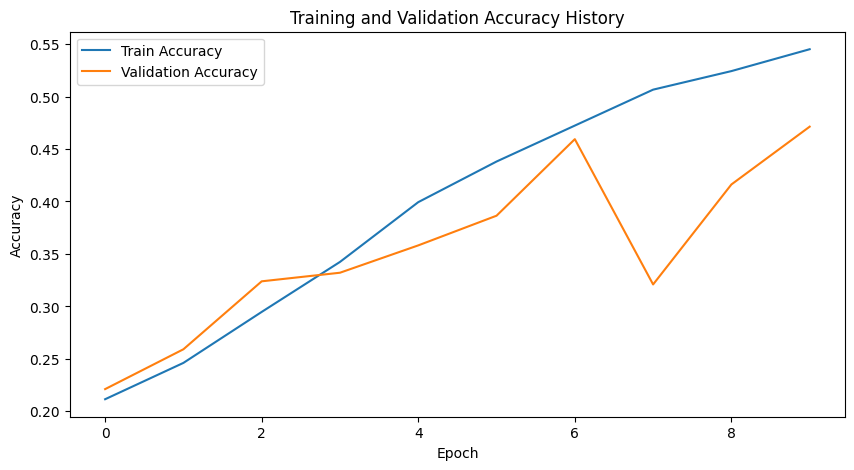

In [26]:
print_history(train_history, val_history, "Training and Validation Accuracy History")

### Подводя итог:
После 10 эпох обучения модель ResNet18 дает результаты точности на обучающей выборке в 54.5% и на валидационной выборке в 47.1%, что не так уж и много. Как мне кажется, это связано с недостатком качественных данных (некоторые повреждены), сложностью задачи. Скорее всего 10 эпох мало для обучения этой модели, а тенденция роста точности с каждой новой эпохой прослеживается, но ресурсы kaggle не сильно позволяют это проверить.